# September 18, 2022: Implement/replicate results in Najafi et al. 2017

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform
from brainiak.fcma.util import compute_correlation

# network analyses
import networkx as nx

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.isc_utils as isc_utils
import helpers.fc_utils as fc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.APPR = 1.0
args.RETR = -1.0
args.LABEL_NAMES = ['RETR', 'APPR']
args.LABELS = [args.RETR, args.APPR]

# arbitrary threshold on proximity
args.near_miss_thresh = 0.7
args.near_miss_width = 8

set_name = 'mashid'

args.main_data_path = (
    f"{proj_dir}/data/emoprox2/data/rois_{set_name}"
)
# os.system(f"mkdir -p {main_output_path}")

args.SEED = 74
np.random.seed(args.SEED)

# ROIs
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"
args.roi_set_df = pd.read_csv(roi_set_file)
args.roi_set_df = args.roi_set_df.sort_values(by=['network'])
# display(args.roi_set_df)

args.roi_names = args.roi_set_df['roi_name'].values
args.nw_names = args.roi_set_df['network'].values
args.roi_idxs = args.roi_set_df.index.values
args.num_rois = len(args.roi_idxs)

# trial level responses
with open(
    f"/home/joyneelm/FORAGING/local/notebooks/dynamical_systems_emoprox/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)

args.trial_option = 'trial'

args.subjects = motion_df.pid.unique()
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

X = dataset_utils.get_emo2_trial_level_responses(
    args, 
    motion_df, 
    args.explor_subjects
)

# change roi ordering
for idx_label, label in enumerate(args.LABELS):
    for idx_subj in range(len(X[idx_label])):
        X[idx_label][idx_subj] = X[idx_label][idx_subj][:, :, args.roi_idxs]

100%|██████████| 30/30 [00:00<00:00, 36.23it/s]

RETR : maxTRs 6
APPR : maxTRs 7


In [3]:
'''
plotting tick labels
'''
ticks = []
for nw in np.unique(args.nw_names):
    ticks.append(np.where(args.nw_names == nw)[0].shape[0])
args.ticks = np.array(ticks)
print(args.ticks)

minor_ticks = np.cumsum(args.ticks)
args.major_ticks = minor_ticks - args.ticks // 2
args.minor_ticks = minor_ticks[:-1]
print(args.minor_ticks)
print(args.major_ticks)

args.major_tick_labels = np.unique(args.nw_names)
print(args.major_tick_labels)

[12 13  8 12]
[12 25 33]
[ 6 19 29 39]
['Executive' 'Salience' 'Subcortical' 'Task negative']


In [4]:
ts = {}
for idx_label, (label, name) in enumerate(zip(args.LABELS, args.LABEL_NAMES)):
    num_TRs = X[idx_label][0].shape[1]
    for tr in range(num_TRs):
        block = f"{name}_TR{tr}"
        ts[block] = []

        for x in X[idx_label]:
            if x.shape[0] <= 8: continue 
            # ignore subjs with l.t.e. 8 trials
            ts[block].append(x[:8, tr, :])

for block in ts.keys():
    ts[block] = np.dstack(ts[block])
    # print(ts[block].shape)

In [5]:
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise = False
args.vectorize_isfcs = True
args.n_bootstraps = 1000

corrs, bootstraps, rois = isc_utils.get_isfcs(args, ts, print_stats=False)

(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(
    args, 
    bootstraps, 
    rois,
    threshold_mats=True
)

 92%|█████████▏| 12/13 [00:14<00:01,  1.21s/it]/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


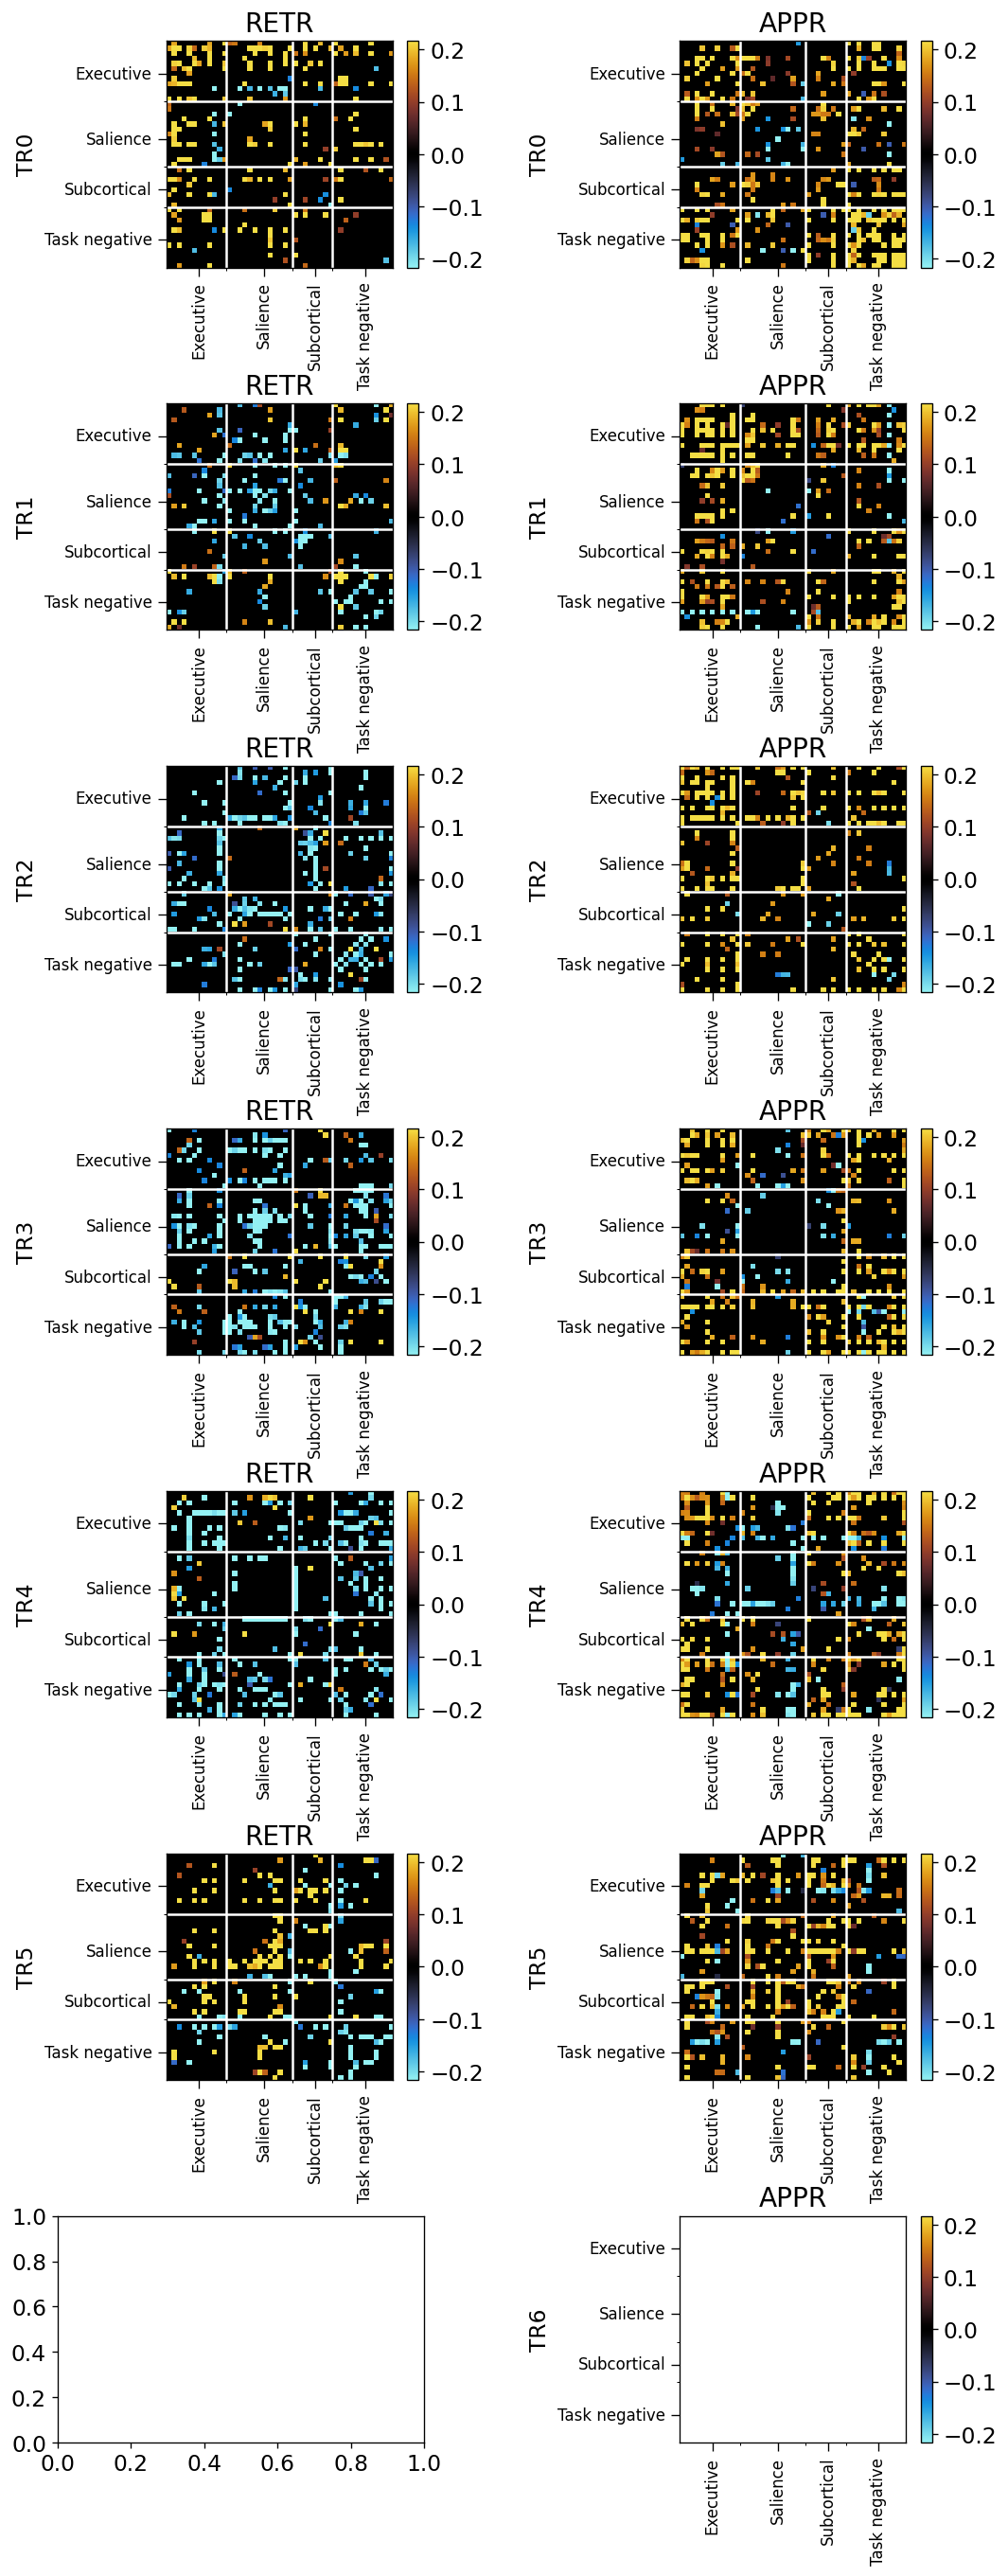

In [6]:
isc_utils.plot_mashid_isfcs(args, observed_isfcs, significant_rois)